In [95]:
import os
import torch
import clip
import chromadb
import numpy as np
from PIL import Image, ExifTags
from tqdm import tqdm
import matplotlib.pyplot as plt

In [118]:
# Load CLIP model and set device
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
model, preprocess = clip.load("ViT-B/16", device=device)

SIMILARITY_CUTOFF = 0.275  # Reasonable threshold to filter low similarity results
IMAGES_PER_ROW = 5
image_dir = "/Users/adityapatil/photos_backup"

chroma_client = chromadb.PersistentClient(path="/Users/adityapatil/GitHub/image-search/chroma_db")

# Initialize Chroma DB client
# try:
#     chroma_client.delete_collection(name="photo_embeddings")
#     print("Deleted existing collection 'photo_embeddings'")
# except:
#     print("No existing collection to delete")

collection = chroma_client.get_or_create_collection(
    name="photo_embeddings", 
    embedding_function=None, 
    metadata={"hnsw:space": "cosine"}
)  # We'll provide embeddings

In [ ]:

def get_image_embeddings(image_paths):
    """
    Extracts CLIP embeddings for a list of images.
    """
    all_embeddings = []
    batch_size = 32
    
    for i in tqdm(range(0, len(image_paths), batch_size), desc="Embedding Images"):
        batch_paths = image_paths[i:i+batch_size]
        images = [preprocess(Image.open(img_path)).unsqueeze(0) for img_path in batch_paths]
        image_inputs = torch.cat(images).to(device)
        
        with torch.no_grad():
            features = model.encode_image(image_inputs)
            features = features / features.norm(dim=-1, keepdim=True)
            
        all_embeddings.append(features.cpu().numpy())
    
    return np.vstack(all_embeddings)

def extract_metadata(image_path):
    """
    Extracts basic metadata (e.g., filename, path). Add EXIF or other metadata as needed.
    """
    return {
        "filename": os.path.basename(image_path),
        "path": image_path,
        # Add more metadata like EXIF if desired
    }

def save_to_chroma(image_paths, embeddings, existing_paths):
    """
    Save only new embeddings to Chroma DB, skipping existing ones.
    """
    ids = [f"img_{i}" for i in range(len(image_paths))]  # IDs based on original index
    metadatas = [extract_metadata(path) for path in image_paths]
    embeddings_list = [embedding.tolist() for embedding in embeddings]
    
    # Filter out existing entries
    new_ids = []
    new_embeddings = []
    new_metadatas = []
    
    for id_, embedding, metadata in zip(ids, embeddings_list, metadatas):
        if metadata["path"] not in existing_paths:
            new_ids.append(id_)
            new_embeddings.append(embedding)
            new_metadatas.append(metadata)
    
    if new_ids:
        collection.add(
            ids=new_ids,
            embeddings=new_embeddings,
            metadatas=new_metadatas
        )
        print(f"Added {len(new_ids)} new embeddings to Chroma DB")
    else:
        print("No new images to add to Chroma DB")

def search_chroma(query_text, top_k=5):
    """
    Searches embeddings and metadata using a natural language query.
    """
    text_embedding = get_text_embedding(query_text)
    results = collection.query(
        query_embeddings=[text_embedding.tolist()],
        n_results=top_k,
        include=["metadatas", "distances"]
    )
    return results

def get_text_embedding(text_query):
    """
    Extracts CLIP embedding for a text query.
    """
    with torch.no_grad():
        text_features = model.encode_text(clip.tokenize([text_query]).to(device))
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    return text_features.cpu().numpy()[0]

def correct_image_orientation(img):
    try:
        for orientation in ExifTags.TAGS.keys():
            if ExifTags.TAGS[orientation] == 'Orientation':
                break
        exif = img._getexif()
        if exif is not None and orientation in exif:
            if exif[orientation] == 3:
                img = img.rotate(180, expand=True)
            elif exif[orientation] == 6:
                img = img.rotate(270, expand=True)
            elif exif[orientation] == 8:
                img = img.rotate(90, expand=True)
    except (AttributeError, KeyError, IndexError):
        pass
    return img

def show_images(image_paths, indices, similarities, title="Top Matching Images"):
    num_cols = 5
    num_images = len(indices)
    num_rows = (num_images + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
    if num_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    for i, (idx, sim) in enumerate(zip(indices, similarities)):
        img = Image.open(image_paths[idx])
        img = correct_image_orientation(img)
        axes[i].imshow(img)
        axes[i].set_title(f"Sim: {sim:.4f}")
        axes[i].axis("off")
    
    for ax in axes[num_images:]:
        ax.axis("off")
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def search_chroma(query_text, image_paths, top_k=10):
    text_embedding = get_text_embedding(query_text)
    
    # Query Chroma DB with cosine similarity
    results = collection.query(
        query_embeddings=[text_embedding.tolist()],
        n_results=top_k,
        include=["metadatas", "distances"]
    )
    
    # Extract matches and similarities
    cosine_matches = [int(id.split('_')[1]) for id in results["ids"][0]]  # Extract index from 'img_<index>'
    cosine_similarities = [1 - dist for dist in results["distances"][0]]  # Convert cosine distance to similarity
    # print(results["distances"][:4])
    # Apply similarity cutoff
    top_m_indices = [idx for idx, sim in zip(cosine_matches, cosine_similarities) if sim >= SIMILARITY_CUTOFF]
    top_m_similarities = [sim for sim in cosine_similarities if sim >= SIMILARITY_CUTOFF]
    
    if len(top_m_indices) == 0:
        print("No image with the description found.")
        print("Would you be interested in seeing other remotely similar images?")
        top_m_indices = cosine_matches[:2]  # Show the top 2 best matches regardless of score
        top_m_similarities = cosine_similarities[:2]
    
    # Print results
    print(f"Filtered Matches Above Similarity Cutoff ({SIMILARITY_CUTOFF}):")
    for idx, sim in zip(top_m_indices, top_m_similarities):
        print(f"{image_paths[idx]} - Similarity: {sim:.4f}")
    
    # Show filtered images with explicit keyword argument
    show_images(
        image_paths=image_paths,
        indices=top_m_indices,
        similarities=top_m_similarities,
        title=f"Filtered Matches for: '{query_text}'"
    )

def get_existing_paths():
    """
    Retrieve paths of images already in the Chroma collection.
    """
    results = collection.get(include=["metadatas"])
    return {meta["path"] for meta in results["metadatas"]} if results["metadatas"] else set()

In [85]:

# Example usage
image_dir = "/Users/adityapatil/photos_backup"
image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.lower().endswith((".jpg", ".png", ".jpeg"))]
print(f"Found {len(image_paths)} images in original folder")

# Check for existing embeddings and process only new images
existing_paths = get_existing_paths()
new_image_paths = [path for path in image_paths if path not in existing_paths]

if new_image_paths:
    image_embeddings = get_image_embeddings(new_image_paths)
    save_to_chroma(new_image_paths, image_embeddings, existing_paths)
    print(f"Embeddings and metadata saved to Chroma DB for {len(new_image_paths)} new images")
else:
    print("All images already exist in Chroma DB, skipping embedding generation")



Found 2949 images in original folder


Embedding Images: 100%|██████████| 93/93 [04:52<00:00,  3.14s/it]


Added 2949 new embeddings to Chroma DB
Embeddings and metadata saved to Chroma DB for 2949 new images


Filtered Matches Above Similarity Cutoff (0.275):
/Users/adityapatil/photos_backup/IMG_5900.JPG - Similarity: 0.3276
/Users/adityapatil/photos_backup/IMG_1481.JPG - Similarity: 0.3213
/Users/adityapatil/photos_backup/IMG_5546.JPG - Similarity: 0.3182
/Users/adityapatil/photos_backup/IMG_5901.JPG - Similarity: 0.3178
/Users/adityapatil/photos_backup/IMG_E3204.JPG - Similarity: 0.3169
/Users/adityapatil/photos_backup/IMG_5982.JPG - Similarity: 0.3159
/Users/adityapatil/photos_backup/IMG_1489.JPG - Similarity: 0.3153
/Users/adityapatil/photos_backup/IMG_5545.JPG - Similarity: 0.3153
/Users/adityapatil/photos_backup/IMG_5567.JPG - Similarity: 0.3142
/Users/adityapatil/photos_backup/IMG_5568.JPG - Similarity: 0.3138
/Users/adityapatil/photos_backup/IMG_5936.JPG - Similarity: 0.3132
/Users/adityapatil/photos_backup/IMG_5898.JPG - Similarity: 0.3132
/Users/adityapatil/photos_backup/IMG_0532.JPG - Similarity: 0.3125
/Users/adityapatil/photos_backup/IMG_5522.JPG - Similarity: 0.3124
/Users/adit

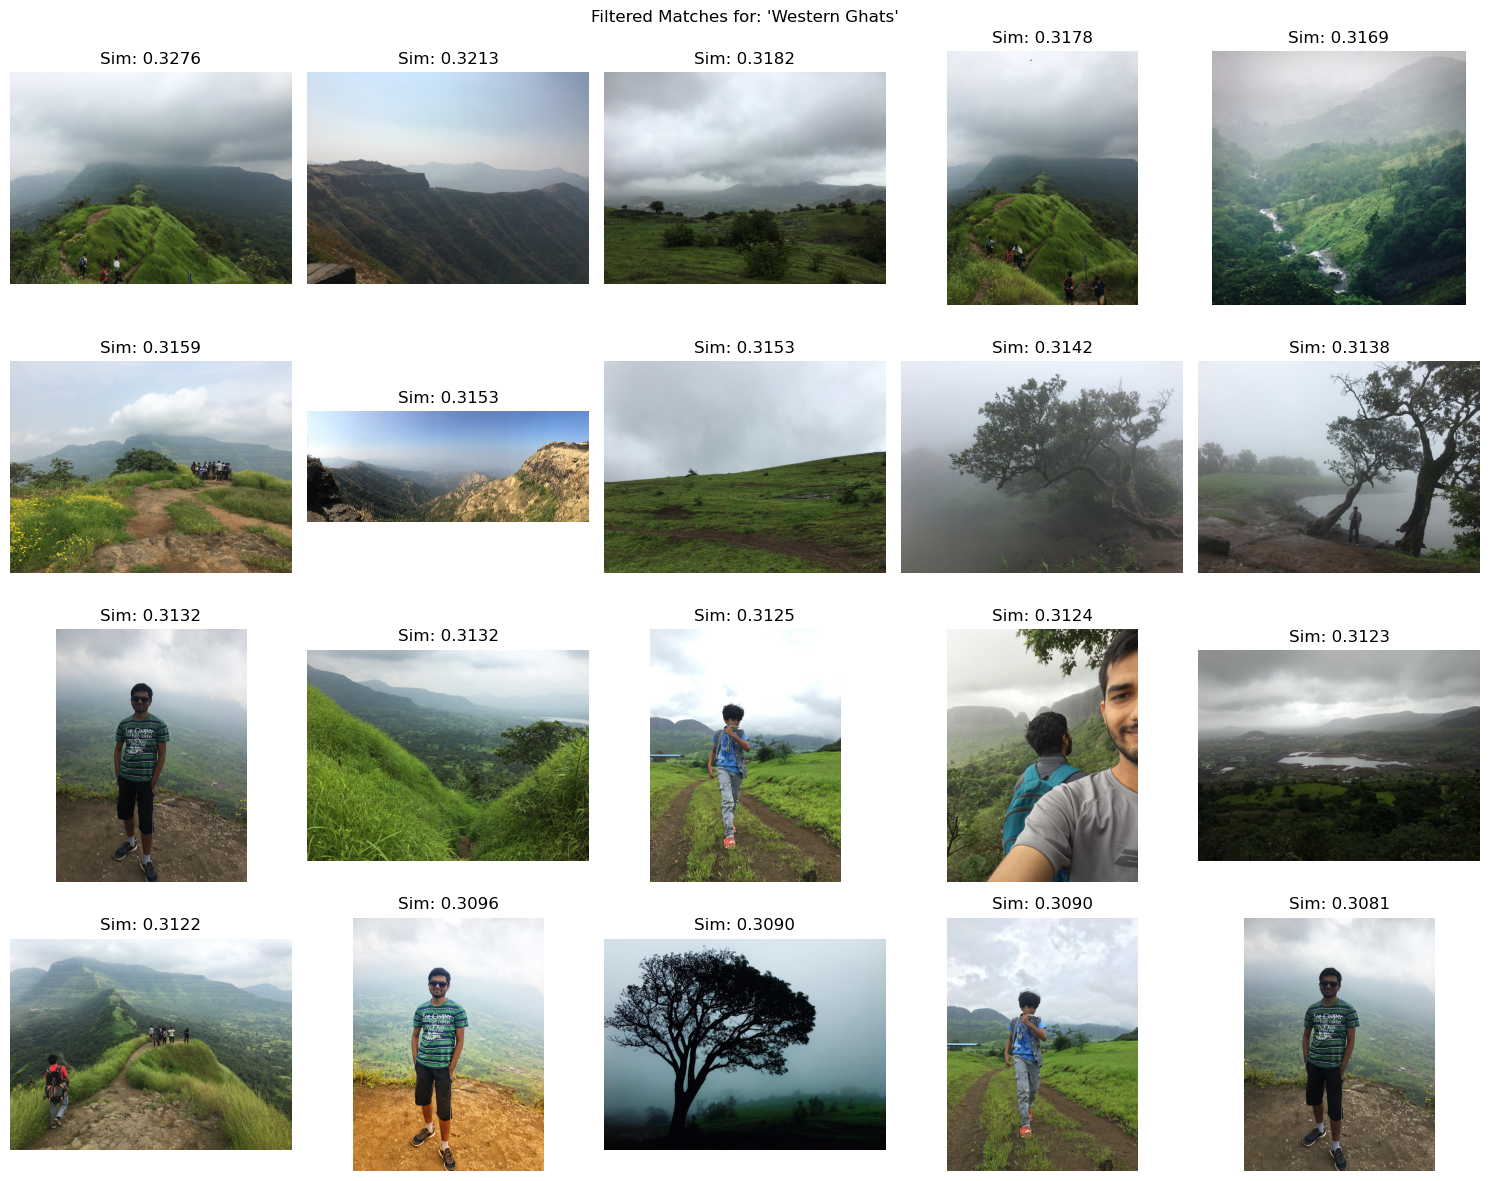

In [94]:
image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.lower().endswith((".jpg", ".png", ".jpeg"))]
# Search and display
query = "Western Ghats"
results = search_chroma(query, image_paths, top_k=20)

# Exploring metadata

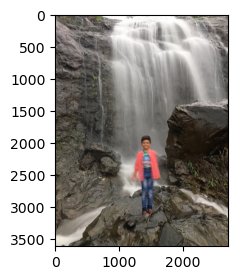

In [ ]:
from PIL.ExifTags import TAGS, GPSTAGS


In [112]:
exif_data = img._getexif()
print(exif_data)

{34853: {1: 'N', 2: (19.0, 41.0, 9.07), 3: 'E', 4: (73.0, 30.0, 30.4), 5: b'\x00', 6: 376.16603773584905, 7: (3.0, 52.0, 16.0), 12: 'K', 13: 0.0, 16: 'T', 17: 22.74478527607362, 23: 'T', 24: 22.74478527607362, 29: '2018:07:14', 31: 5.0}, 296: 2, 34665: 180, 271: 'Apple', 272: 'iPhone 6s', 305: '11.3', 306: '2018:07:14 09:22:18', 282: 72.0, 283: 72.0, 36864: b'0221', 37121: b'\x01\x02\x03\x00', 37377: 5.059471365638767, 36867: '2018:07:14 09:22:18', 36868: '2018:07:14 09:22:18', 37378: 2.2750072066878064, 37379: 4.061928219563687, 37380: 0.0, 37383: 5, 37385: 16, 37386: 4.15, 40961: 1, 40962: 2710, 41989: 29, 41990: 0, 40963: 3617, 37521: '978', 37522: '978', 37396: (2239, 1466, 133, 133), 41495: 2, 33434: 0.030303030303030304, 33437: 2.2, 41729: b'\x01', 34850: 2, 34855: 32, 41986: 0, 40960: b'0100', 41987: 0, 42034: (4.15, 4.15, 2.2, 2.2), 42035: 'Apple', 42036: 'iPhone 6s back camera 4.15mm f/2.2', 37500: b'Apple iOS\x00\x00\x01MM\x00\x10\x00\x01\x00\t\x00\x00\x00\x01\x00\x00\x00\t\x

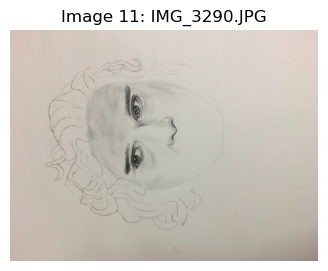


EXIF Metadata for /Users/adityapatil/photos_backup/IMG_3290.JPG:
--------------------------------------------------
GPSInfo (ID: 34853):
  GPSLatitudeRef: N
  GPSLatitude: (20.0, 10.0, 24.71)
  GPSLongitudeRef: E
  GPSLongitude: (73.0, 58.0, 24.01)
  GPSAltitudeRef: b'\x00'
  GPSAltitude: 614.3020134228188
  GPSTimeStamp: (20.0, 8.0, 59.0)
  GPSSpeedRef: K
  GPSSpeed: 0.86
  GPSImgDirectionRef: T
  GPSImgDirection: 19.26400759734093
  GPSDestBearingRef: T
  GPSDestBearing: 19.26400759734093
  GPSDateStamp: 2017:07:14
  GPSHPositioningError: 5.0
ResolutionUnit (ID: 296): 2
ExifOffset (ID: 34665): 204
Software (ID: 305): 10.3
Orientation (ID: 274): 6
DateTime (ID: 306): 2017:07:15 01:38:59
YCbCrPositioning (ID: 531): 1
XResolution (ID: 282): 72.0
YResolution (ID: 283): 72.0
ExifVersion (ID: 36864): b'0221'
ComponentsConfiguration (ID: 37121): b'\x01\x02\x03\x00'
ShutterSpeedValue (ID: 37377): 5.059471365638767
DateTimeOriginal (ID: 36867): 2017:07:15 01:38:59
DateTimeDigitized (ID: 3686

In [121]:
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
import os
import matplotlib.pyplot as plt

def dms_to_decimal(degrees, minutes, seconds, direction):
    """
    Convert DMS (degrees, minutes, seconds) to decimal degrees.
    Direction is 'N', 'S', 'E', or 'W'.
    """
    decimal = degrees + (minutes / 60.0) + (seconds / 3600.0)
    if direction in ['S', 'W']:
        decimal = -decimal
    return decimal

def get_exif_metadata(image_path):
    """
    Extract and print name, latitude, longitude, and all other EXIF metadata.
    """
    try:
        # Open the image
        img = Image.open(image_path)
        
        # Get EXIF data
        exif_data = img._getexif()
        
        if exif_data is None:
            print(f"No EXIF data found in {image_path}")
            return
        
        # Initialize variables for specific fields
        name = None  # Could be interpreted as filename, Make, Model, etc.
        latitude = None
        longitude = None
        
        print(f"\nEXIF Metadata for {image_path}:")
        print("-" * 50)
        
        # Process all EXIF tags
        for tag_id, value in exif_data.items():
            tag_name = TAGS.get(tag_id, f"Unknown Tag (ID: {tag_id})")
            
            # Handle specific tags
            if tag_name == "ImageDescription" or tag_name == "Make" or tag_name == "Model":
                name = value  # Use as 'name' if available
            elif tag_name == "GPSInfo" and isinstance(value, dict):
                # Extract GPS data
                gps_info = {GPSTAGS.get(k, f"Unknown GPS Tag (ID: {k})"): v for k, v in value.items()}
                
                # Latitude
                if "GPSLatitude" in gps_info and "GPSLatitudeRef" in gps_info:
                    lat = gps_info["GPSLatitude"]  # (degrees, minutes, seconds)
                    lat_ref = gps_info["GPSLatitudeRef"]  # 'N' or 'S'
                    latitude = dms_to_decimal(lat[0], lat[1], lat[2], lat_ref)
                
                # Longitude
                if "GPSLongitude" in gps_info and "GPSLongitudeRef" in gps_info:
                    lon = gps_info["GPSLongitude"]  # (degrees, minutes, seconds)
                    lon_ref = gps_info["GPSLongitudeRef"]  # 'E' or 'W'
                    longitude = dms_to_decimal(lon[0], lon[1], lon[2], lon_ref)
                
                # Print GPSInfo as a whole
                print(f"{tag_name} (ID: {tag_id}):")
                for gps_tag, gps_value in gps_info.items():
                    print(f"  {gps_tag}: {gps_value}")
            else:
                # Print other tags
                print(f"{tag_name} (ID: {tag_id}): {value}")
        
        # Print specific fields at the top
        print("\nSpecific Fields:")
        print("-" * 50)
        print(f"name: {name if name else 'Not found'}")
        print(f"latitude: {latitude if latitude is not None else 'Not found'}")
        print(f"longitude: {longitude if longitude is not None else 'Not found'}")
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
    finally:
        img.close()

# Example usage
if __name__ == "__main__":
    # image_dir = "/Users/adityapatil/Pictures/Kuari Pass"
    image_dir = "/Users/adityapatil/photos_backup"
    image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.lower().endswith((".jpg", ".png", ".jpeg"))]
    
    image_num = 11
    if 0 <= image_num < len(image_paths):
        # Display the image
        img = Image.open(image_paths[image_num])
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 3))  # Corrected argument names
        ax.imshow(img)
        ax.axis("off")  # Hide axes
        plt.title(f"Image {image_num}: {os.path.basename(image_paths[image_num])}")
        plt.show()
        
        # Print EXIF metadata
        get_exif_metadata(image_paths[image_num])
    else:
        print(f"Invalid image number {image_num}. Must be between 0 and {len(image_paths) - 1}")